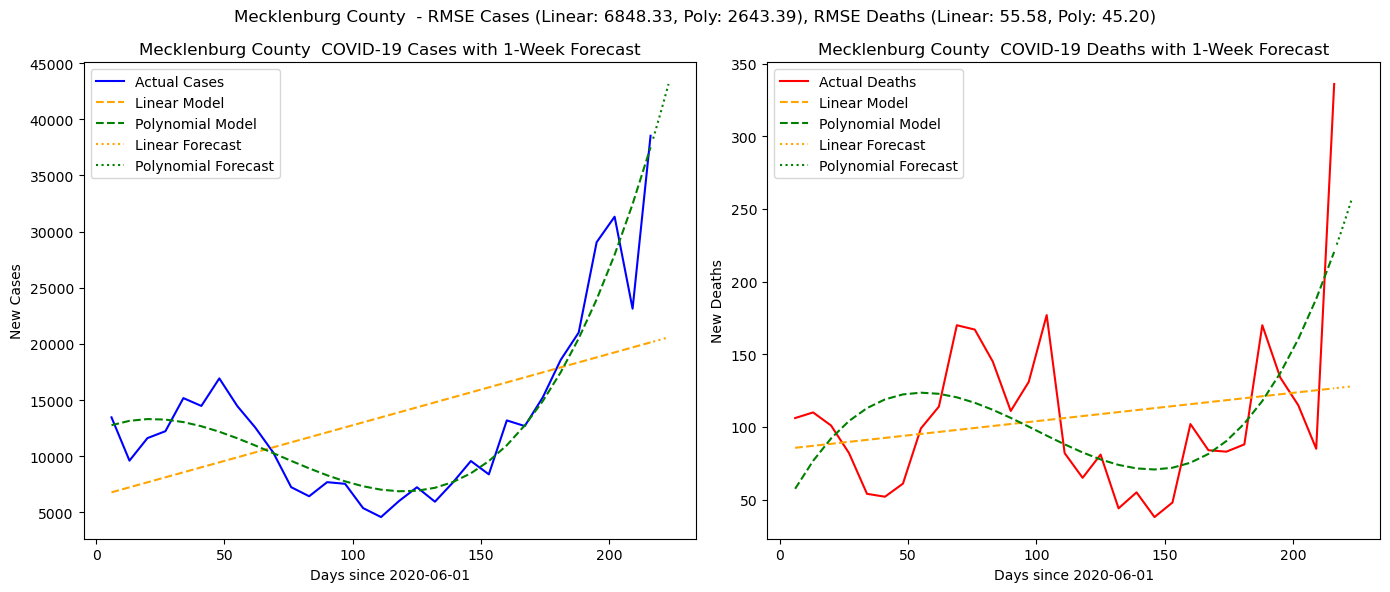

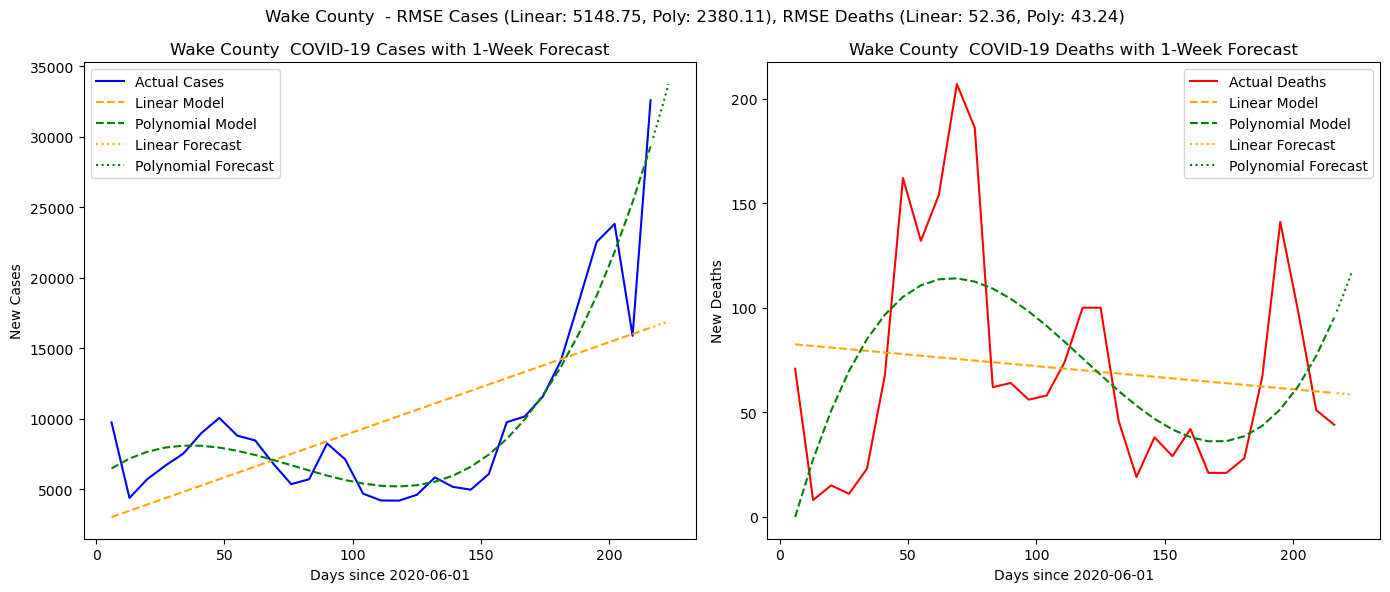

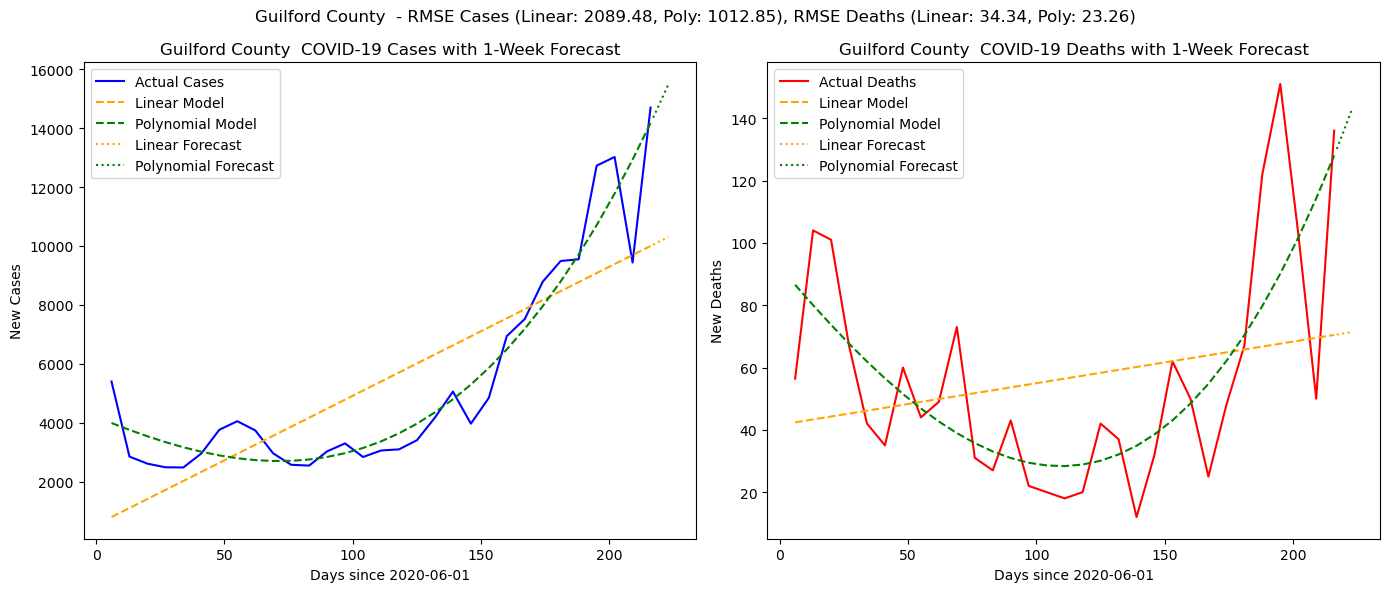

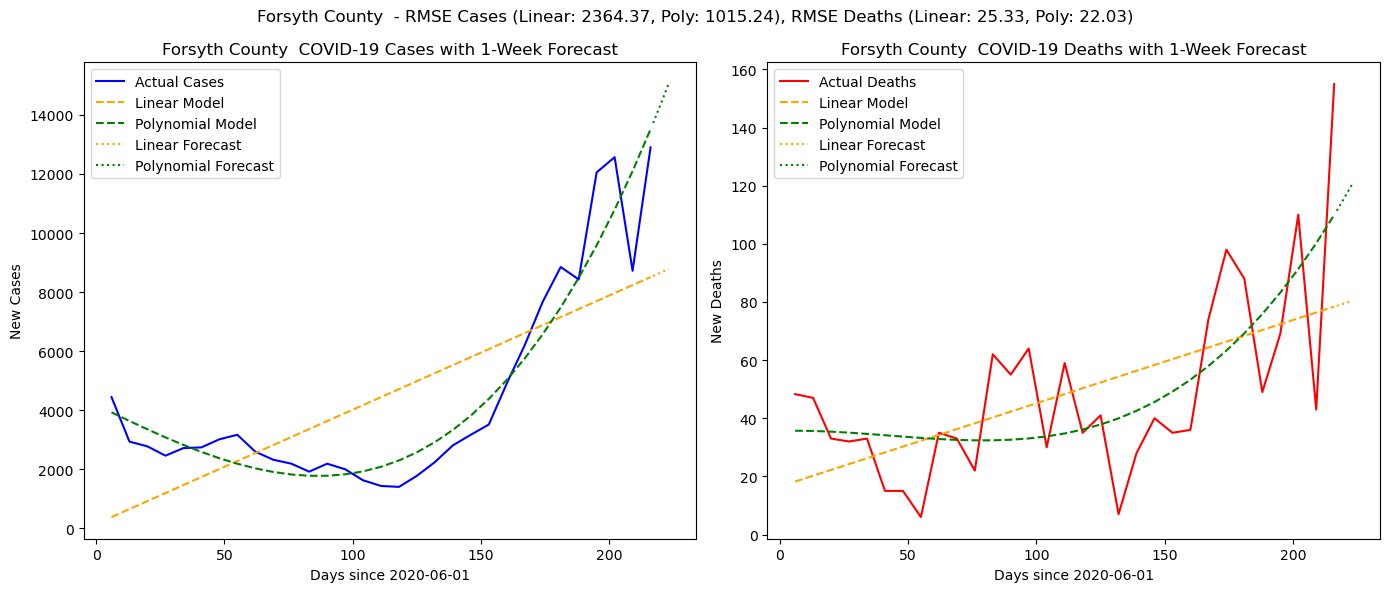

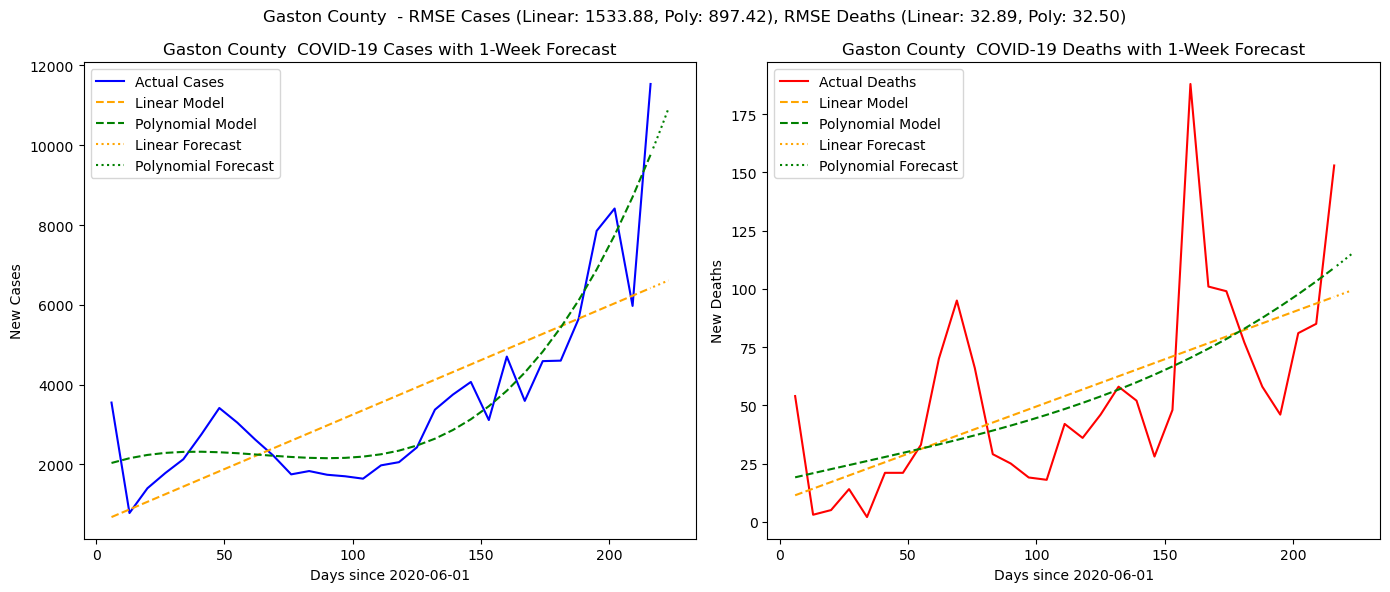

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load cases and deaths data
cases_data = pd.read_csv('NC_weekly_cases.csv')
deaths_data = pd.read_csv('NC_weekly_deaths.csv')

# Filter for North Carolina
cases_data = cases_data[cases_data['State'] == 'NC']
deaths_data = deaths_data[deaths_data['State'] == 'NC']

# Identify date columns for cases and deaths
case_columns = [col for col in cases_data.columns if '_cases' in col]
death_columns = [col for col in deaths_data.columns if '_deaths' in col]

# Sum cases and deaths over the entire period to identify top counties by cases
top_counties = cases_data.groupby('County Name_x')[case_columns].sum().sum(axis=1).nlargest(5).index
cases_data = cases_data[cases_data['County Name_x'].isin(top_counties)]
deaths_data = deaths_data[deaths_data['County Name_x'].isin(top_counties)]

# Reshape data from wide to long format for easier analysis
cases_long = cases_data.melt(id_vars=['County Name_x', 'population'], value_vars=case_columns, 
                             var_name='date', value_name='cases')
deaths_long = deaths_data.melt(id_vars=['County Name_x', 'population'], value_vars=death_columns, 
                               var_name='date', value_name='deaths')

# Convert date strings to datetime format and calculate days since start
cases_long['date'] = pd.to_datetime(cases_long['date'].str.replace('_cases', ''), format='%Y-%m-%d')
deaths_long['date'] = pd.to_datetime(deaths_long['date'].str.replace('_deaths', ''), format='%Y-%m-%d')
cases_long['days_since_start'] = (cases_long['date'] - pd.to_datetime('2020-06-01')).dt.days
deaths_long['days_since_start'] = (deaths_long['date'] - pd.to_datetime('2020-06-01')).dt.days

# Define a function to fit linear and polynomial models and return predictions, RMSE, and one-week forecast
def fit_and_evaluate_with_forecast(X, y, degree=3, forecast_days=7):
    # Reshape X for fitting
    X = X.values.reshape(-1, 1)
    
    # Linear regression
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Polynomial regression
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # Calculate RMSE using numpy
    rmse_linear = np.sqrt(np.mean((y - y_pred_linear) ** 2))
    rmse_poly = np.sqrt(np.mean((y - y_pred_poly) ** 2))
    
    # Generate forecast for the next week
    forecast_X = np.array([[X.max() + i] for i in range(1, forecast_days + 1)])
    forecast_linear = linear_model.predict(forecast_X)
    forecast_poly = poly_model.predict(poly_features.transform(forecast_X))
    
    return y_pred_linear, y_pred_poly, rmse_linear, rmse_poly, forecast_X.flatten(), forecast_linear, forecast_poly

# Analyze each top county
for county in top_counties:
    # Extract cases and deaths for the current county
    county_cases = cases_long[cases_long['County Name_x'] == county]
    county_deaths = deaths_long[deaths_long['County Name_x'] == county]
    
    # Prepare X (days) and y (cases or deaths) data
    X = county_cases[['days_since_start']]
    y_cases = county_cases['cases']
    y_deaths = county_deaths['deaths']
    
    # Fit and evaluate models for cases with one-week forecast
    y_cases_pred_linear, y_cases_pred_poly, rmse_cases_linear, rmse_cases_poly, forecast_X, forecast_cases_linear, forecast_cases_poly = fit_and_evaluate_with_forecast(X, y_cases)
    
    # Fit and evaluate models for deaths with one-week forecast
    y_deaths_pred_linear, y_deaths_pred_poly, rmse_deaths_linear, rmse_deaths_poly, _, forecast_deaths_linear, forecast_deaths_poly = fit_and_evaluate_with_forecast(X, y_deaths)
    
    # Plot the cases and deaths trends along with forecast
    plt.figure(figsize=(14, 6))
    
    # Plot cases
    plt.subplot(1, 2, 1)
    plt.plot(county_cases['days_since_start'], y_cases, label="Actual Cases", color="blue")
    plt.plot(county_cases['days_since_start'], y_cases_pred_linear, label="Linear Model", linestyle="--", color="orange")
    plt.plot(county_cases['days_since_start'], y_cases_pred_poly, label="Polynomial Model", linestyle="--", color="green")
    plt.plot(forecast_X, forecast_cases_linear, label="Linear Forecast", linestyle=":", color="orange")
    plt.plot(forecast_X, forecast_cases_poly, label="Polynomial Forecast", linestyle=":", color="green")
    plt.title(f"{county} COVID-19 Cases with 1-Week Forecast")
    plt.xlabel("Days since 2020-06-01")
    plt.ylabel("New Cases")
    plt.legend()
    
    # Plot deaths
    plt.subplot(1, 2, 2)
    plt.plot(county_deaths['days_since_start'], y_deaths, label="Actual Deaths", color="red")
    plt.plot(county_deaths['days_since_start'], y_deaths_pred_linear, label="Linear Model", linestyle="--", color="orange")
    plt.plot(county_deaths['days_since_start'], y_deaths_pred_poly, label="Polynomial Model", linestyle="--", color="green")
    plt.plot(forecast_X, forecast_deaths_linear, label="Linear Forecast", linestyle=":", color="orange")
    plt.plot(forecast_X, forecast_deaths_poly, label="Polynomial Forecast", linestyle=":", color="green")
    plt.title(f"{county} COVID-19 Deaths with 1-Week Forecast")
    plt.xlabel("Days since 2020-06-01")
    plt.ylabel("New Deaths")
    plt.legend()
    
    # Display the RMSE for each model in the title
    plt.suptitle(f"{county} - RMSE Cases (Linear: {rmse_cases_linear:.2f}, Poly: {rmse_cases_poly:.2f}), "
                 f"RMSE Deaths (Linear: {rmse_deaths_linear:.2f}, Poly: {rmse_deaths_poly:.2f})")
    plt.tight_layout()
    plt.show()


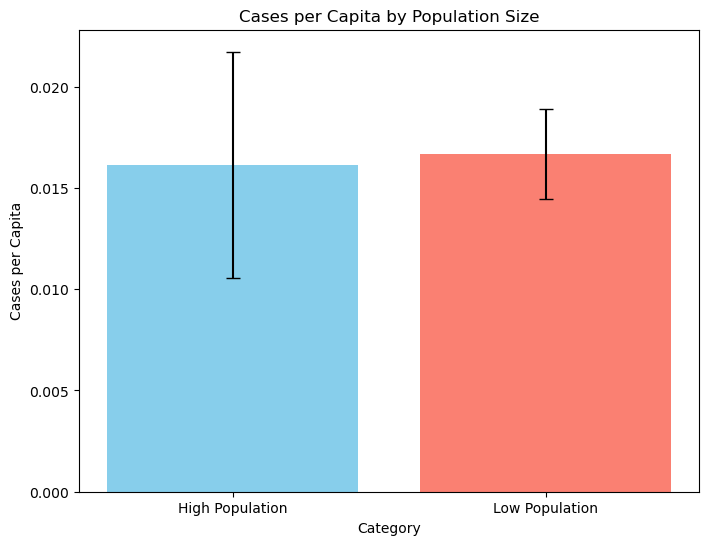

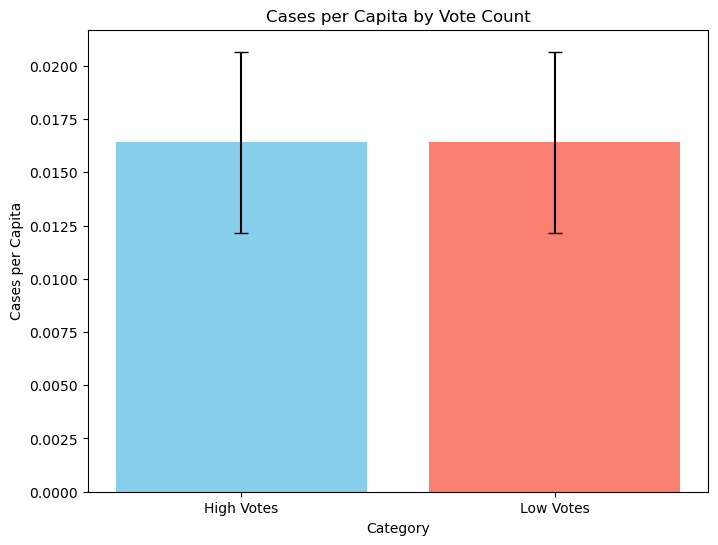

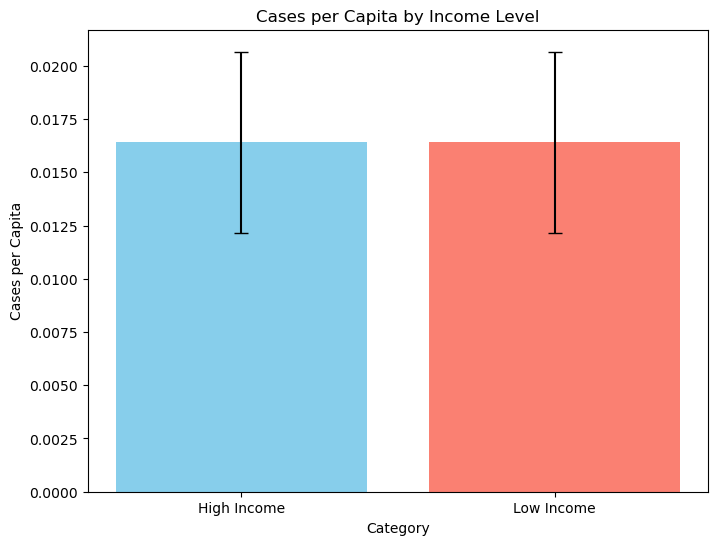

In [12]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Merging COVID data and enrichment data
covid_data = pd.DataFrame({
    'State': ['NC', 'NC', 'NC', 'NC', 'NC', 'NC'],
    'County Name': ['Mecklenburg', 'Forsyth', 'Guilford', 'Wake', 'Durham', 'Buncombe'],
    '2020-06-07_cases': [9606, 2932, 2853, 1134, 1745, 879],
    '2020-06-14_cases': [11612, 2772, 2615, 1278, 1930, 944],
    '2020-06-21_cases': [12227, 2456, 2491, 1375, 2054, 1010],
    'population': [1110356, 382295, 537174, 1091400, 321488, 261191],
})

enrichment_data = pd.DataFrame({
    'State': ['NC', 'NC', 'NC', 'NC', 'NC', 'NC'],
    'County Name': ['Mecklenburg', 'Forsyth', 'Guilford', 'Wake', 'Durham', 'Buncombe'],
    'total_votes': [378107, 113033, 173086, 273547, 136450, 75460],
    'party': ['DEM', 'REP', 'DEM', 'DEM', 'DEM', 'REP'],
    'income_level': [50588, 37241, 36563, 60221, 48950, 42415],
})

# Merge and calculate per capita
merged_data = pd.merge(covid_data, enrichment_data, how='inner', on='State')
weekly_case_columns = [col for col in merged_data.columns if 'cases' in col]
merged_data['total_cases'] = merged_data[weekly_case_columns].sum(axis=1)
merged_data['cases_per_capita'] = merged_data['total_cases'] / merged_data['population']
party_mapping = {'REP': 0, 'DEM': 1}
merged_data['party_numerical'] = merged_data['party'].map(party_mapping)

# Define a function to calculate confidence intervals
def calculate_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - margin, mean + margin

# Function to plot with confidence intervals
def plot_with_confidence_intervals(data1, data2, labels, title):
    means, conf_intervals = [], []
    for data in [data1, data2]:
        mean, lower, upper = calculate_confidence_interval(data)
        means.append(mean)
        conf_intervals.append((lower, upper))
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.bar(labels, means, yerr=[(means[0] - conf_intervals[0][0], means[1] - conf_intervals[1][0])], 
            capsize=5, color=['skyblue', 'salmon'], label="Mean ± CI")
    plt.title(title)
    plt.ylabel('Cases per Capita')
    plt.xlabel('Category')
    plt.show()

# 1. Population vs. Cases per Capita with Confidence Intervals
pop_median = merged_data['population'].median()
pop_high = merged_data[merged_data['population'] > pop_median]['cases_per_capita']
pop_low = merged_data[merged_data['population'] <= pop_median]['cases_per_capita']
plot_with_confidence_intervals(pop_high, pop_low, ['High Population', 'Low Population'], 'Cases per Capita by Population Size')

# 2. Total Votes vs. Cases per Capita with Confidence Intervals
votes_median = merged_data['total_votes'].median()
votes_high = merged_data[merged_data['total_votes'] > votes_median]['cases_per_capita']
votes_low = merged_data[merged_data['total_votes'] <= votes_median]['cases_per_capita']
plot_with_confidence_intervals(votes_high, votes_low, ['High Votes', 'Low Votes'], 'Cases per Capita by Vote Count')

# 3. Income Level vs. Cases per Capita with Confidence Intervals
income_median = merged_data['income_level'].median()
income_high = merged_data[merged_data['income_level'] > income_median]['cases_per_capita']
income_low = merged_data[merged_data['income_level'] <= income_median]['cases_per_capita']
plot_with_confidence_intervals(income_high, income_low, ['High Income', 'Low Income'], 'Cases per Capita by Income Level')

